In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skin-cancer-images/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024371.jpg
/kaggle/input/skin-cancer-images/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024358.jpg
/kaggle/input/skin-cancer-images/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024337.jpg
/kaggle/input/skin-cancer-images/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024382.jpg
/kaggle/input/skin-cancer-images/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024420.jpg
/kaggle/input/skin-cancer-images/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024409.jpg
/kaggle/input/skin-cancer-images/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

In [19]:
#Importing all the important libraries
import pathlib
import tensorflow as tf

import numpy as np
import pandas as pd

import os
import PIL

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("../input/skin-cancer-images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("../input/skin-cancer-images/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [24]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(f"Training images = {image_count_train}")
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(f"Test images = {image_count_test}")

Training images = 2239
Test images = 118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [25]:
batch_size = 32
img_height = 180
img_width = 180

SEED = 123
EPOCHS = 15


Use 80% of the images for training, and 20% for validation.

In [28]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir_train, 
                                                               seed=SEED, validation_split=0.2, subset = "training",
                                                               batch_size=batch_size, image_size=(img_height,img_width))

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [29]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir_train, 
                                                               seed=SEED, validation_split=0.2, subset = "validation",
                                                            batch_size=batch_size, image_size=(img_height,img_width))

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [30]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

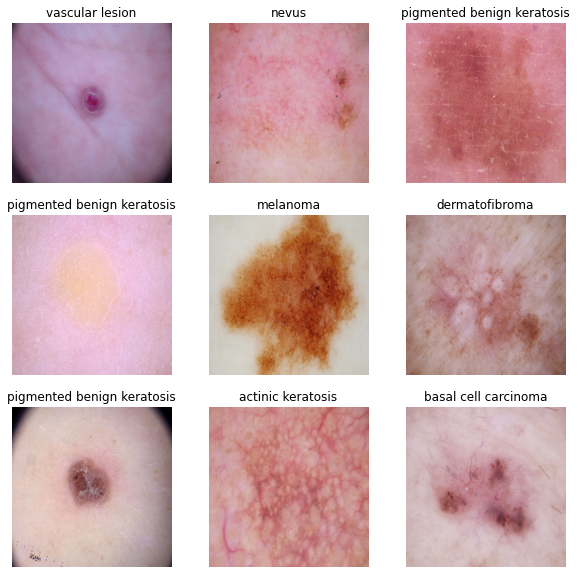

In [32]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [34]:
# Creating CNN

num_classes = 9

model = Sequential([
  # Layer set -1                  
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, kernel_size=(3, 3),activation='relu'),
  layers.Conv2D(32,kernel_size=(3, 3), activation='relu'),
  layers.MaxPool2D(pool_size = (2, 2)),

  # Layer set -2
  layers.Conv2D(64, (3, 3), activation='relu',padding = 'Same'),
  layers.Conv2D(64, (3, 3), activation='relu',padding = 'Same'),
  layers.MaxPool2D(pool_size=(2, 2)),

  # Layer set -3
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [37]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [38]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 176, 176, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 88, 88, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 88, 88, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 88, 88, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 44, 44, 64)        0

### Train the model

In [40]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
56/56 [==============================] - 197s 3s/step - loss: 2.0386 - accuracy: 0.2065 - val_loss: 1.9236 - val_accuracy: 0.2573
Epoch 2/15
56/56 [==============================] - 172s 3s/step - loss: 1.9293 - accuracy: 0.2852 - val_loss: 1.7585 - val_accuracy: 0.3893
Epoch 3/15
56/56 [==============================] - 171s 3s/step - loss: 1.7430 - accuracy: 0.3705 - val_loss: 1.7281 - val_accuracy: 0.4161
Epoch 4/15
56/56 [==============================] - 170s 3s/step - loss: 1.5475 - accuracy: 0.4314 - val_loss: 1.6944 - val_accuracy: 0.4362
Epoch 5/15
56/56 [==============================] - 170s 3s/step - loss: 1.5274 - accuracy: 0.4581 - val_loss: 1.5410 - val_accuracy: 0.4855
Epoch 6/15
56/56 [==============================] - 170s 3s/step - loss: 1.4629 - accuracy: 0.4978 - val_loss: 1.4821 - val_accuracy: 0.5190
Epoch 7/15
56/56 [==============================] - 170s 3s/step - loss: 1.3563 - accuracy: 0.5140 - val_loss: 1.4381 - val_accuracy: 0.5213
Epoch 8/15
56

### Visualizing training results

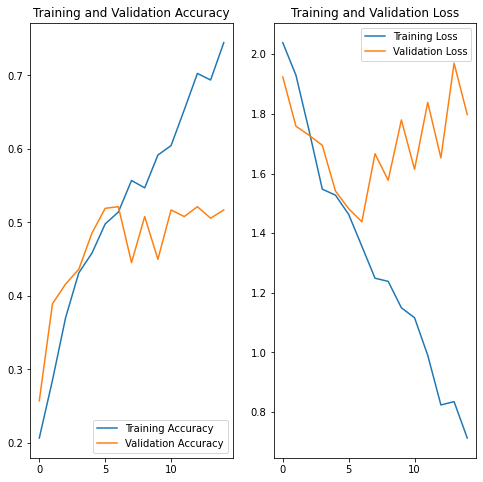

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here:
The above model is clearly overfitting since the training accuracy, is greater than the validation accuracy by leaps and bounds Also in terms of ‘loss’, overfitting reveals itself when our model show a low values for the training loss and a higher values in the validation loss.

Hence the model is Overfitting To overcome overfitting we'll be adding Dropout and Data Argumentation layers to randomize the data and decrease overfitting

### Todo:
### Create the model, compile and train the model

In [42]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
# data argumentation layer

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", seed=SEED),
  layers.experimental.preprocessing.RandomRotation(0.2, seed=SEED),
  layers.experimental.preprocessing.RandomZoom(height_factor=(-0.5, 0.5), width_factor=(-0.5, 0.5), fill_mode='reflect',interpolation='bilinear', seed=SEED),
  
])

FOLDER == ../input/skin-cancer-images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis
FOLDER == ../input/skin-cancer-images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma
FOLDER == ../input/skin-cancer-images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion
FOLDER == ../input/skin-cancer-images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis
FOLDER == ../input/skin-cancer-images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma
FOLDER == ../input/skin-cancer-images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma
FOLDER == ../input/skin-cancer-images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis
FOLDER == ../input/skin-cancer-images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma
F

<Figure size 1440x1440 with 0 Axes>

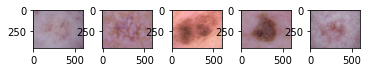

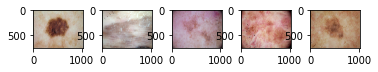

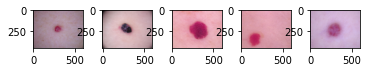

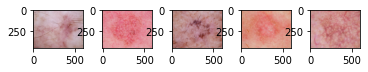

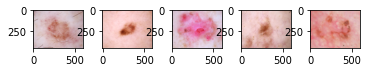

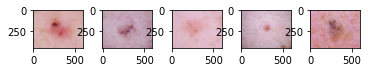

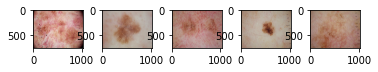

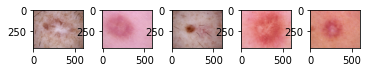

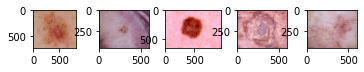

In [45]:

# visualizing argumented data from each class(5 samples from each class type)

plt.figure(figsize=(20, 20))
directory=os.listdir(data_dir_train)
for each in directory:
    plt.figure()
    currentFolder = f"{data_dir_train}/{each}"
    print(f"FOLDER == {currentFolder}")
    for i, file in enumerate(os.listdir(currentFolder)[0:5]):        
        fullpath = f"{currentFolder}/{file}"
        img=plt.imread(fullpath)
        plt.subplot(5,5,i+1)
        plt.imshow(img)

In [47]:
# Creating CNN
model = Sequential([
  # Layer set -1                  
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  data_augmentation,
  layers.Conv2D(32, kernel_size=(3, 3),activation='relu'),
  layers.Conv2D(32,kernel_size=(3, 3), activation='relu'),
  layers.MaxPool2D(pool_size = (2, 2)),
  layers.Dropout(0.15),

  # Layer set -2
  layers.Conv2D(64, (3, 3), activation='relu',padding = 'Same'),
  layers.Conv2D(64, (3, 3), activation='relu',padding = 'Same'),
  layers.MaxPool2D(pool_size=(2, 2)),
  layers.Dropout(0.2),

  # Layer set -3
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation='softmax')
])

In [48]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [49]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 176, 176, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 88, 88, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 88, 88, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 88, 88, 64)       

In [51]:
## Your code goes here, note: train your model for 20 epochs
# fitting our model
EPOCHS = 20
history = model.fit(train_ds, batch_size=batch_size, validation_data=val_ds, epochs=EPOCHS)

Epoch 1/20
56/56 [==============================] - 191s 3s/step - loss: 2.9776 - accuracy: 0.1977 - val_loss: 1.8930 - val_accuracy: 0.3669
Epoch 2/20
56/56 [==============================] - 181s 3s/step - loss: 1.9077 - accuracy: 0.3164 - val_loss: 1.8859 - val_accuracy: 0.3221
Epoch 3/20
56/56 [==============================] - 181s 3s/step - loss: 1.8934 - accuracy: 0.3039 - val_loss: 1.6251 - val_accuracy: 0.4228
Epoch 4/20
56/56 [==============================] - 191s 3s/step - loss: 1.7754 - accuracy: 0.3456 - val_loss: 1.6382 - val_accuracy: 0.4340
Epoch 5/20
56/56 [==============================] - 180s 3s/step - loss: 1.6965 - accuracy: 0.3988 - val_loss: 1.9427 - val_accuracy: 0.3154
Epoch 6/20
56/56 [==============================] - 180s 3s/step - loss: 1.8325 - accuracy: 0.3495 - val_loss: 1.5717 - val_accuracy: 0.4430
Epoch 7/20
56/56 [==============================] - 188s 3s/step - loss: 1.6552 - accuracy: 0.4008 - val_loss: 1.5170 - val_accuracy: 0.4631
Epoch 8/20
56

### Visualizing the results

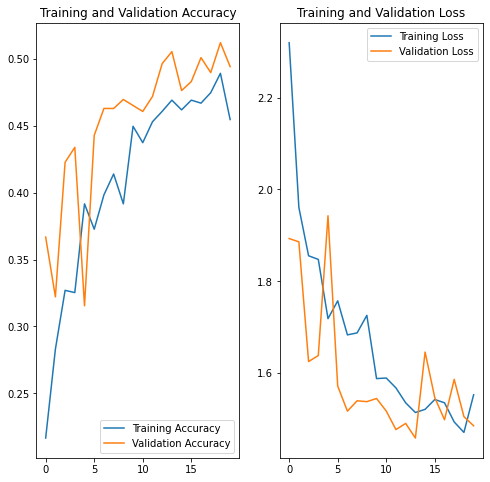

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?


We can visualize that the issue of overfitting is resolved now and our model is more generalized. But the accuracy of the model is still quite low.

This might be a result of less number of samples available for training our model.

Let's observe number of samples present in each class

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [58]:
directory=os.listdir(data_dir_train)
for each in directory:
    currentFolder = f"{data_dir_train}/{each}"
    print(f"Class Name => {each}")
    print(f"--------------- Class length =>{len(os.listdir(currentFolder))}")

Class Name => pigmented benign keratosis
--------------- Class length =>462
Class Name => melanoma
--------------- Class length =>438
Class Name => vascular lesion
--------------- Class length =>139
Class Name => actinic keratosis
--------------- Class length =>114
Class Name => squamous cell carcinoma
--------------- Class length =>181
Class Name => basal cell carcinoma
--------------- Class length =>376
Class Name => seborrheic keratosis
--------------- Class length =>77
Class Name => dermatofibroma
--------------- Class length =>95
Class Name => nevus
--------------- Class length =>357


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


Hence class seborrheic keratosis has least number of samples and class pigmented benign keratosis has most number of samples

This is a class imbalance problem. Lets resolve it...

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

In [ ]:
# generating 500 argumented for each sample

import Augmentor

directory=os.listdir(data_dir_train)
for each in class_names:
    currentFolder = f"{data_dir_train}/{each}"
    p = Augmentor.Pipeline(currentFolder)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
image_count_train

### Lets see the distribution of augmented data after adding new images to the original training data.

In [77]:
directory=os.listdir(data_dir_train)
for each in directory:
    currentFolder = f"{data_dir_train}/{each}"
    old_class_length = len(os.listdir(currentFolder))
    new_class_length = len(os.listdir(f"{currentFolder}/output/"))
    print(f"Class Name => {each}")
    print(f"--------------- Class length =>{old_class_length+new_class_length}")

['pigmented benign keratosis',
 'melanoma',
 'vascular lesion',
 'actinic keratosis',
 'squamous cell carcinoma',
 'basal cell carcinoma',
 'seborrheic keratosis',
 'dermatofibroma',
 'nevus']

In [83]:
#lets train the model on the data created using Augmentor
data_dir_train_new = data_dir_train

#new training dataset
train_ds_new = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=SEED,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [91]:
# new validation dataset
val_ds_new = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir_train, 
                                                               seed=SEED, validation_split=0.2, subset = "validation",
                                                            batch_size=batch_size, image_size=(img_height, img_width))

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


### Lets create a CNN based on new training data

In [93]:
# Creating CNN
model_new = Sequential([
  # Layer set -1                  
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, kernel_size=(3, 3),activation='relu'),
  layers.Conv2D(32,kernel_size=(3, 3), activation='relu'),
  layers.MaxPool2D(pool_size = (2, 2)),
  layers.Dropout(0.15),

  # Layer set -2
  layers.Conv2D(64, (3, 3), activation='relu',padding = 'Same'),
  layers.Conv2D(64, (3, 3), activation='relu',padding = 'Same'),
  layers.MaxPool2D(pool_size=(2, 2)),
  layers.Dropout(0.2),

  # Layer set -3
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation='softmax')
])

In [94]:
# Compile the model
model_new.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [95]:
# View the summary of all layers
model_new.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 178, 178, 32)      896       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 176, 176, 32)      9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 88, 88, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 88, 88, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 88, 88, 64)        18496     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 88, 88, 64)       

In [96]:
# fitting our model
history = model_new.fit(train_ds_new, batch_size=batch_size, validation_data=val_ds_new, epochs=30)

Epoch 1/30
56/56 [==============================] - 182s 3s/step - loss: 2.1829 - accuracy: 0.2369 - val_loss: 1.7873 - val_accuracy: 0.3915
Epoch 2/30
56/56 [==============================] - 178s 3s/step - loss: 1.7875 - accuracy: 0.3569 - val_loss: 1.6613 - val_accuracy: 0.4407
Epoch 3/30
56/56 [==============================] - 177s 3s/step - loss: 1.7139 - accuracy: 0.3958 - val_loss: 1.7330 - val_accuracy: 0.4787
Epoch 4/30
56/56 [==============================] - 176s 3s/step - loss: 1.6034 - accuracy: 0.4602 - val_loss: 1.5218 - val_accuracy: 0.5123
Epoch 5/30
56/56 [==============================] - 178s 3s/step - loss: 1.5783 - accuracy: 0.4513 - val_loss: 1.5028 - val_accuracy: 0.4877
Epoch 6/30
56/56 [==============================] - 177s 3s/step - loss: 1.4584 - accuracy: 0.4876 - val_loss: 1.4237 - val_accuracy: 0.5324
Epoch 7/30
56/56 [==============================] - 178s 3s/step - loss: 1.3912 - accuracy: 0.5220 - val_loss: 1.5431 - val_accuracy: 0.5145
Epoch 8/30
56

In [ ]:
# Visualizing model metrices
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

So, As we can see that this model had a decent amount of accuracy and also the problem of overfitting is fixed.
Therefore we may accept this model to make further predictions, as it is both accurate and generalized in nature.
